# Imports and installs

In [1]:
pip install fastcluster==1.2.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import StandardScaler, LabelEncoder

from scipy.stats import t
from scipy.sparse import lil_matrix
from scipy.spatial.distance import pdist, squareform, euclidean
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from fastcluster import linkage as flinkage

# EDA

## Load and observe data

In [3]:
data = pd.read_csv("/kaggle/input/private-blood-count/data/data/full_revised_labelled_data_4_sets_with_control_all_dropped.csv")
first = data.iloc[:, :58]
scaler = StandardScaler() # mean 0, sd 1
cols = first.columns
first = pd.DataFrame(scaler.fit_transform(first), columns = cols)

/tmp/ipykernel_35/2843240984.py:1: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/kaggle/input/private-blood-count/data/data/full_revised_labelled_data_4_sets_with_control_all_dropped.csv")


In [4]:
first

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),NRBC#(10^3/uL),NRBC%(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
0,-0.488683,-1.317669,-1.737478,-1.896340,-2.023263,-1.283238,0.437636,-1.124243,0.126584,0.738468,...,6.582619,0.934308,-0.496115,-0.420124,2.292319,-1.850357,0.972860,2.390416,0.921461,1.307501
1,0.341113,1.586205,1.988623,1.452953,-0.526869,0.461497,1.528997,2.055760,1.534830,1.104867,...,8.369883,0.285129,0.291758,0.952752,1.819581,-0.148674,1.296751,2.343140,1.438079,1.790415
2,-0.266828,0.830985,0.811959,0.420465,-1.085048,-0.101320,1.267070,-0.064242,0.523080,1.035076,...,7.281090,0.726571,0.199387,0.522046,1.920164,-1.075034,0.889574,1.161250,0.411641,1.577035
3,-0.257032,0.894807,0.772737,0.458239,-1.132552,-0.270166,1.048798,-0.166822,0.427374,0.825706,...,7.507066,1.142045,-0.023391,0.320152,2.111271,-1.316693,0.482397,2.390416,0.350463,0.925662
4,-0.497903,-1.434675,-1.737478,-1.984479,-1.975758,-0.973688,0.961489,-1.117404,0.167600,0.965286,...,7.609782,-0.078412,-0.267903,1.437296,2.282261,-1.266348,1.268989,2.532243,0.642760,0.667359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79416,-0.235710,1.788307,2.184733,1.780328,-0.313099,0.433356,1.179761,-0.050564,-0.064829,-0.064118,...,-0.258291,-0.935328,-0.267903,-0.702774,-1.137548,-0.586682,-0.146878,1.066699,0.037773,0.352903
79417,-0.085886,2.096777,2.459288,2.158068,-0.218090,0.377075,0.917835,0.086210,-0.064829,-0.064118,...,-0.196661,-0.571788,-0.229868,-0.231690,-0.171955,-0.727649,-0.035829,-0.162466,-0.206941,-0.040167
79418,-0.192492,0.650158,0.733515,0.710065,-0.051824,0.067525,0.175709,0.906856,-0.064829,-0.064118,...,0.337464,-0.130346,-0.441779,0.024042,0.190142,-0.516198,0.371348,0.570305,0.126142,0.375364
79419,-0.236863,1.522384,1.674846,1.138170,-0.990039,0.123807,1.572651,-0.036887,-0.064829,-0.064118,...,-0.463723,-0.390018,-0.219001,0.064421,-0.473703,-0.541370,-0.396736,0.830321,-0.941082,0.476439


## (Dropping) Highly correlated pairs

In [5]:
def find_high_correlated_pairs(df, threshold=0.97):
    """
    Finds pairs of columns with absolute correlation >= threshold, avoiding redundancy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The correlation threshold.

    Returns:
        list: A list of tuples, where each tuple contains the names of highly correlated columns.
    """

    corr_matrix = df.corr().abs()
    high_corr_pairs = {}
    seen_pairs = set()  # To track pairs we've already found

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # Start j from i + 1 to avoid redundancy
            col_a = corr_matrix.columns[i]
            col_b = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]

            if abs(correlation) >= threshold:
                pair = tuple(sorted((col_a, col_b)))  # Sort to ensure consistent order
                if pair not in seen_pairs:
                    high_corr_pairs[pair] = correlation
                    seen_pairs.add(pair)

    return high_corr_pairs

In [6]:
high_corr_pairs = find_high_correlated_pairs(first, threshold = 0.9)
print("Highly correlated pairs:")
count = 1
for pair, corr in high_corr_pairs.items():
    p1, p2 = pair
    print(f"{count}: ({p1}, {p2}) =  {corr}")
    count += 1

Highly correlated pairs:
1: (WBC(10^3/uL), [TNC(10^3/uL)]) =  0.9991441821030644
2: (WBC(10^3/uL), [WBC-N(10^3/uL)]) =  1.0
3: (WBC(10^3/uL), [TNC-N(10^3/uL)]) =  0.9991441821030644
4: (WBC(10^3/uL), [WBC-D(10^3/uL)]) =  0.9997085921635317
5: (WBC(10^3/uL), [TNC-D(10^3/uL)]) =  0.9989250869195913
6: (HGB(g/dL), RBC(10^6/uL)) =  0.9013981657285917
7: (HCT(%), RBC(10^6/uL)) =  0.9337647131040651
8: (HCT(%), HGB(g/dL)) =  0.9762186691639434
9: (PLT(10^3/uL), [PLT-I(10^3/uL)]) =  0.9997111815287222
10: (NEUT#(10^3/uL), [NEUT#&(10^3/uL)]) =  0.9522578039440388
11: (LYMPH#(10^3/uL), [LYMP#&(10^3/uL)]) =  0.9994469483639629
12: (BASO#(10^3/uL), [BA-N#(10^3/uL)]) =  0.9529120296982188
13: (BASO#(10^3/uL), [BA-D#(10^3/uL)]) =  0.9027231486714389
14: (LYMPH%(%), NEUT%(%)) =  0.916346093968014
15: (NEUT%(%), [NEUT%&(%)]) =  0.976838014221264
16: (NEUT%(%), [LYMP%&(%)]) =  0.9104405670987389
17: (LYMPH%(%), [LYMP%&(%)]) =  0.9971204961416765
18: (BASO%(%), [BA-N%(%)]) =  0.9723620558384032
19: ([T

In [7]:
drop_list = ["[TNC(10^3/uL)]", "[WBC-N(10^3/uL)]", "[TNC-N(10^3/uL)]", "[WBC-D(10^3/uL)]", "[TNC-D(10^3/uL)]"]
second = first.copy()
second.drop(drop_list, axis = 1, inplace = True)
second

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),NRBC#(10^3/uL),NRBC%(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
0,-0.488683,-1.317669,-1.737478,-1.896340,-2.023263,-1.283238,0.437636,-1.124243,0.126584,0.738468,...,6.582619,0.934308,-0.496115,-0.420124,2.292319,-1.850357,0.972860,2.390416,0.921461,1.307501
1,0.341113,1.586205,1.988623,1.452953,-0.526869,0.461497,1.528997,2.055760,1.534830,1.104867,...,8.369883,0.285129,0.291758,0.952752,1.819581,-0.148674,1.296751,2.343140,1.438079,1.790415
2,-0.266828,0.830985,0.811959,0.420465,-1.085048,-0.101320,1.267070,-0.064242,0.523080,1.035076,...,7.281090,0.726571,0.199387,0.522046,1.920164,-1.075034,0.889574,1.161250,0.411641,1.577035
3,-0.257032,0.894807,0.772737,0.458239,-1.132552,-0.270166,1.048798,-0.166822,0.427374,0.825706,...,7.507066,1.142045,-0.023391,0.320152,2.111271,-1.316693,0.482397,2.390416,0.350463,0.925662
4,-0.497903,-1.434675,-1.737478,-1.984479,-1.975758,-0.973688,0.961489,-1.117404,0.167600,0.965286,...,7.609782,-0.078412,-0.267903,1.437296,2.282261,-1.266348,1.268989,2.532243,0.642760,0.667359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79416,-0.235710,1.788307,2.184733,1.780328,-0.313099,0.433356,1.179761,-0.050564,-0.064829,-0.064118,...,-0.258291,-0.935328,-0.267903,-0.702774,-1.137548,-0.586682,-0.146878,1.066699,0.037773,0.352903
79417,-0.085886,2.096777,2.459288,2.158068,-0.218090,0.377075,0.917835,0.086210,-0.064829,-0.064118,...,-0.196661,-0.571788,-0.229868,-0.231690,-0.171955,-0.727649,-0.035829,-0.162466,-0.206941,-0.040167
79418,-0.192492,0.650158,0.733515,0.710065,-0.051824,0.067525,0.175709,0.906856,-0.064829,-0.064118,...,0.337464,-0.130346,-0.441779,0.024042,0.190142,-0.516198,0.371348,0.570305,0.126142,0.375364
79419,-0.236863,1.522384,1.674846,1.138170,-0.990039,0.123807,1.572651,-0.036887,-0.064829,-0.064118,...,-0.463723,-0.390018,-0.219001,0.064421,-0.473703,-0.541370,-0.396736,0.830321,-0.941082,0.476439


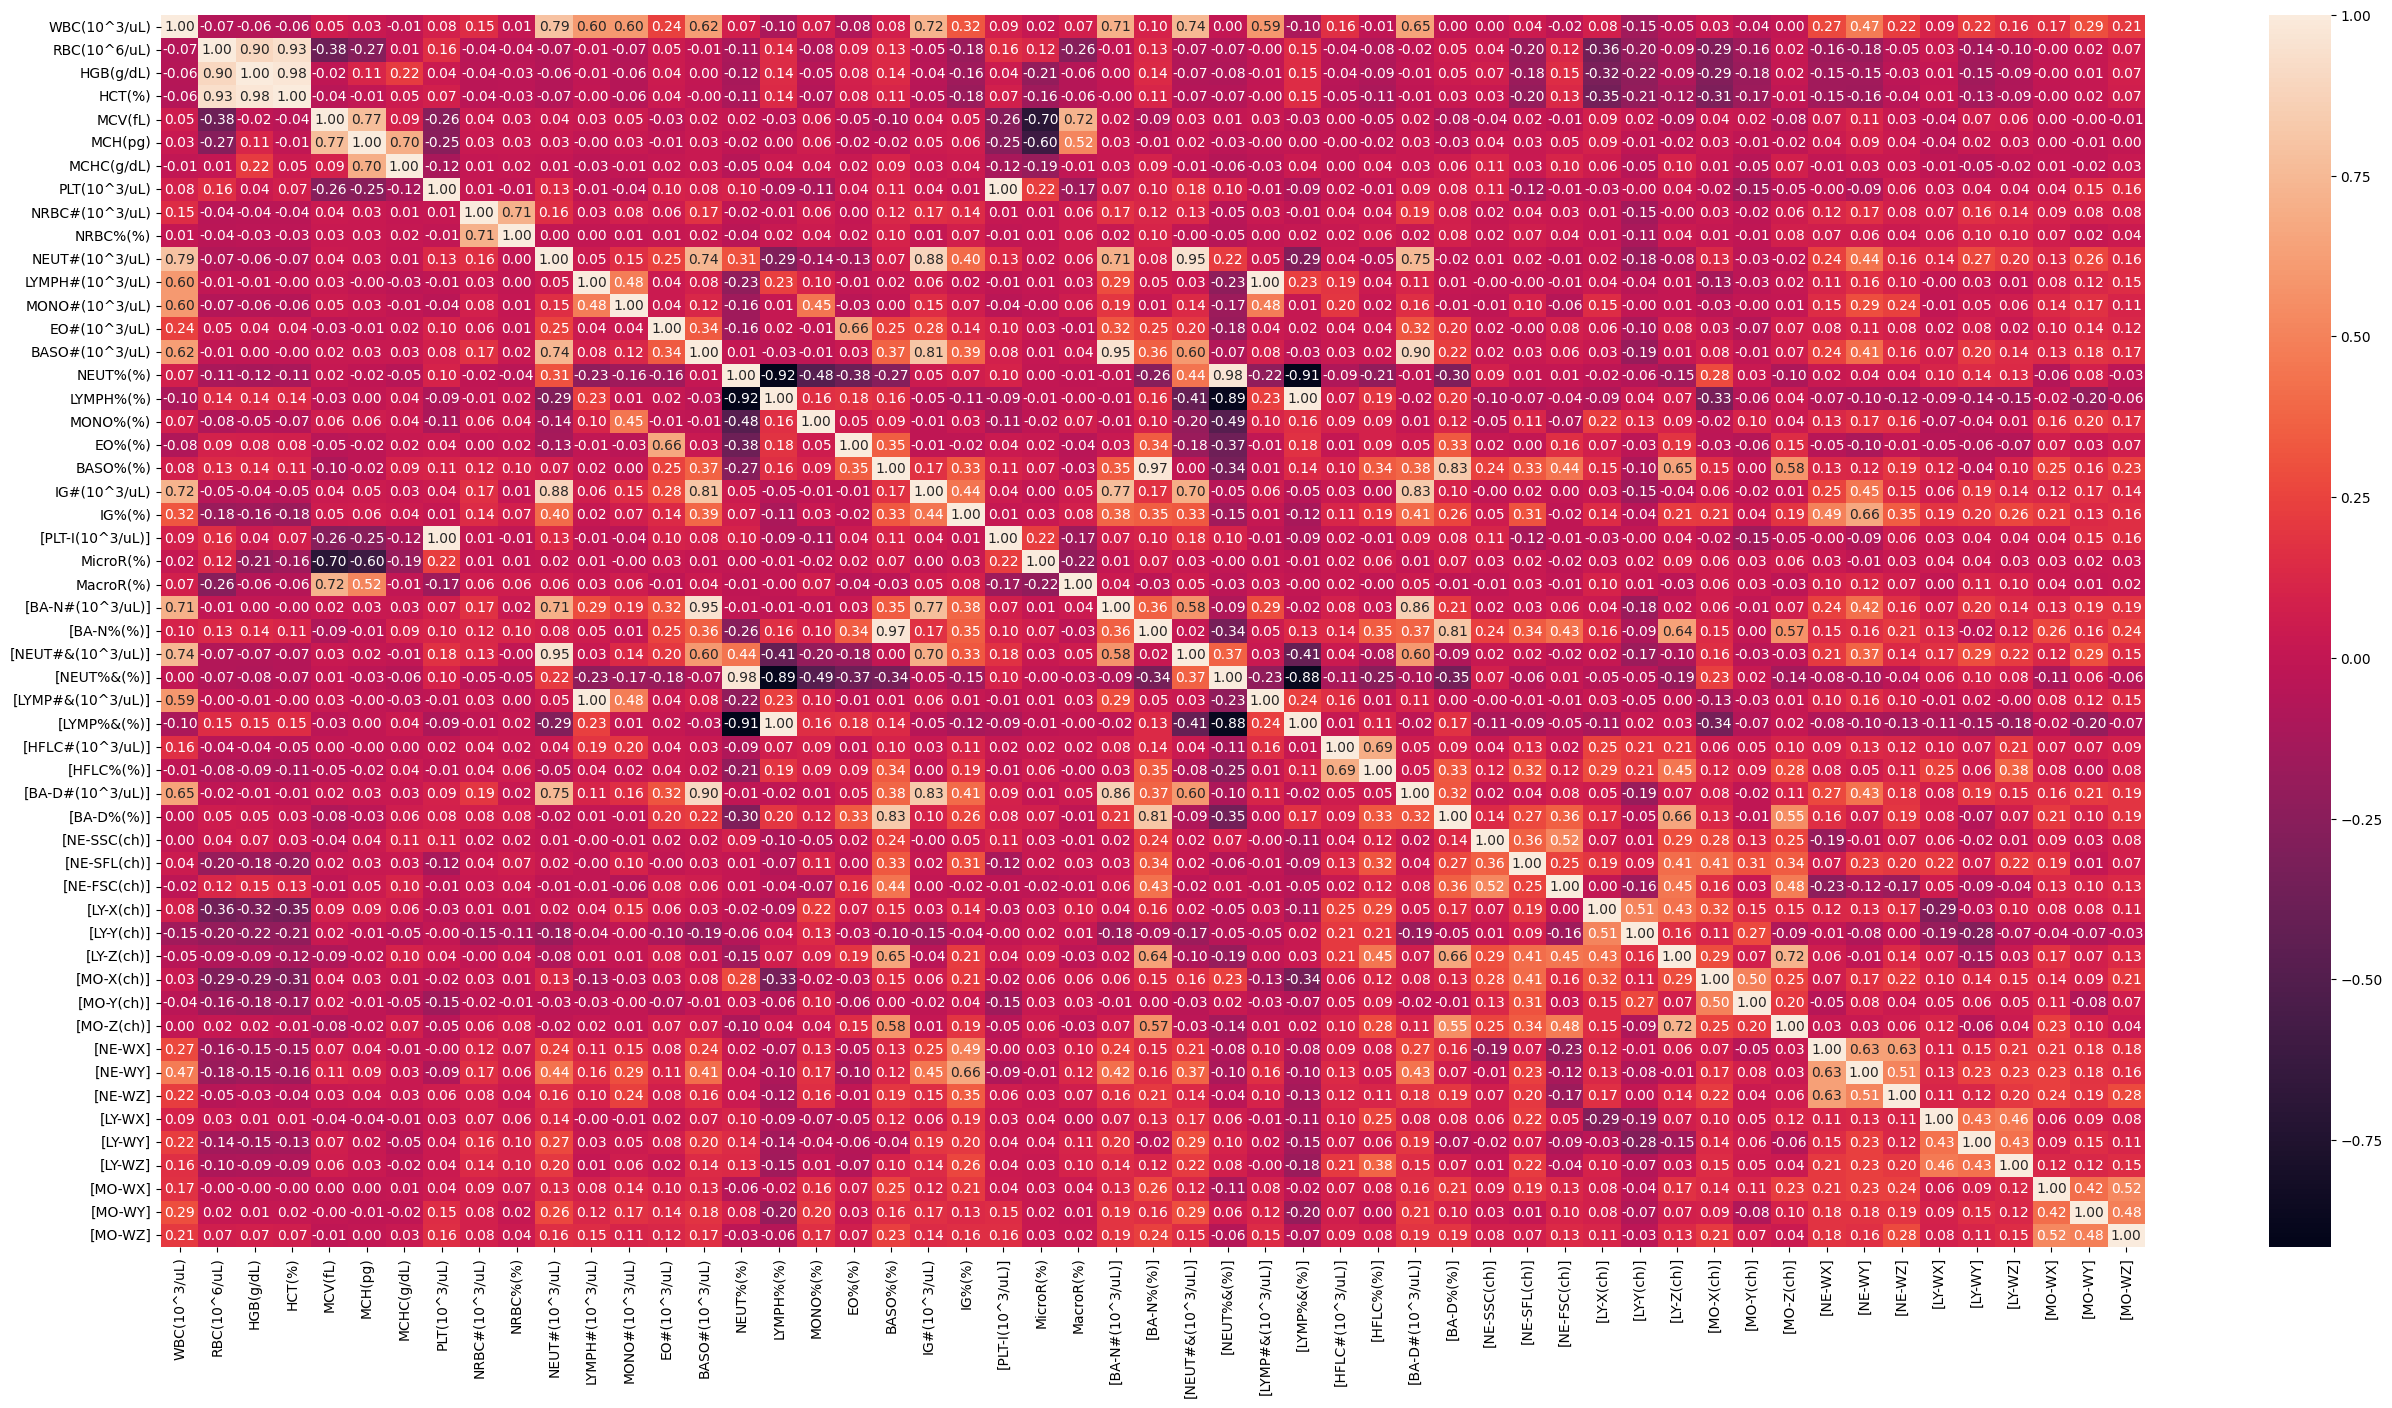

In [8]:
plt.figure(figsize = (32, 16))
sns.heatmap(second.corr(), annot = True, fmt = '.2f')
plt.show()

# Clusters!

## Clustering process

In [ ]:
tic = time.time()
# Z_ward_dropped = flinkage(second, method = 'ward', metric = 'euclidean')
Z_avg_dropped = flinkage(second, method = 'average', metric = 'euclidean')
toc = time.time()
print(f"{toc - tic} seconds.")

## t-SNE plot generation

In [10]:
# tic = time.time()
# tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
# data_2d_tsne = tsne.fit_transform(second)
# toc = time.time()
# print(f"{toc - tic} seconds")

In [12]:
Z_ward_dropped = np.loadtxt('/kaggle/input/private-blood-count/data/data/Z_ward_dropped_medical_nb_clone_1.txt', dtype = 'float')
data_2d_tsne_dropped = np.loadtxt('/kaggle/input/private-blood-count/data/data/data_2d_tsne_dropped_medical_nb_clone_1.txt', dtype = 'float')

In [13]:
labels = data['Revised final diagnosis']

In [14]:
# plt.figure(figsize = (20, 20))
# plt.scatter(data_2d_tsne_dropped[:, 0], data_2d_tsne_dropped[:, 1], s = 3)
# plt.show()

## Fill null values (i.e. undiagnosed) and map labels

In [15]:
labels

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
79416    Control
79417    Control
79418    Control
79419    Control
79420    Control
Name: Revised final diagnosis, Length: 79421, dtype: object

In [16]:
labels.unique()

array([nan, 'Chronic lymphocytic leukemia', 'Primary myelofibrosis',
       'Acute myeloid leukemia non M3', 'Chronic myeloid leukemia',
       'Plasma cell leukemia', 'Acute lymphoblastic leukemia',
       'Acute leukemia', 'Multiple myeloma',
       'Myeloproliferative neoplasm', 'Aplastic anemia',
       'Myelodysplastic neoplasm with increased blasts-2',
       'T-cell Non Hodgkin lymphoma',
       'Myelodysplastic neoplasm with increased blasts-1',
       'Acute promyelocytic leukemia', 'Eosinophilia',
       'B-cell Non Hodgkin lymphoma', 'Essential thrombocythaemia',
       'Burkitts lymphoma', 'Chronic Idiopathic thrombocytopenic purpura',
       'Infiltration by metastatic carcinoma ', 'Renal osteodystrophy',
       'Myelodysplastic neoplasm with low blasts', 'Control'],
      dtype=object)

In [17]:
mapped_labels = labels.copy()
control_label = 'Control'
control_value = 1

# unique disease labels (without undiagnosed, i.e. nan and control)
unique_diagnosis_strings = labels.dropna().loc[labels.dropna() != control_label].unique()
sorted_strings = sorted(unique_diagnosis_strings)

# map the diagnoses from 1 to n, avoid 0 and 1
string_to_int_map = {string: i + 2 for i, string in enumerate(sorted_strings)}

# control is mapped to 0
string_to_int_map[control_label] = control_value

# helper function to handle mapping
def map_func(x):
    if pd.isna(x):
        return 0  # nan (undiagnosed) mapped to 0
    elif x in string_to_int_map:
        return string_to_int_map[x]
    else:
        return x # return original if not found (e.g., if it's already an int from prior mapping)

mapped_labels = mapped_labels.apply(map_func)

In [18]:
mapped_labels = labels.fillna(0)
unique_strings = labels.dropna().unique()
sorted_strings = sorted(unique_strings)
string_to_int_map = {string: i + 1 for i, string in enumerate(sorted_strings)}
mapped_labels = mapped_labels.map(lambda x: string_to_int_map[x] if isinstance(x, str) else x)
mapped_labels

0         0
1         0
2         0
3         0
4         0
         ..
79416    11
79417    11
79418    11
79419    11
79420    11
Name: Revised final diagnosis, Length: 79421, dtype: int64

## Obtaining threshold?

### Function to obtain highest clustering threshold in which the purity of clusters (containing labelled points) is at least `min_purity` (here we are dealing with purity of labelled points, i.e. if there are 4 labelled points in a cluster of 50 then the purity of those 4 points must be `min_purity`; above this point we are getting more impure and mixed clusters)

In [19]:
def find_optimal_threshold(Z, labels, min_purity=0.5, num_thresholds=100):
    thresholds = np.linspace(0, Z[-1, 2], num_thresholds)  # Explore 100 thresholds
    best_threshold = 0
    count = 0
    for t in thresholds:
        # print(t)
        clusters = fcluster(Z, t, criterion='distance')
        # return clusters
        pure = True
        for cluster_id in np.unique(clusters):
            # return clusters
            cluster_labels = labels[clusters == cluster_id]
            disease_cluster_labels = cluster_labels[cluster_labels != 0]
            # if count == 1 and len(disease_cluster_labels) > 0:
            #     print(f"{cluster_id}: {len(disease_cluster_labels)}")
            if len(disease_cluster_labels) > 0:
                # if count == 1:
                #     print(disease_cluster_labels)
                majority = np.bincount(disease_cluster_labels).argmax()
                purity = np.mean(disease_cluster_labels == majority)
                if purity < min_purity:
                    pure = False
                    break
        count += 1
        print(pure)
        if pure:
            best_threshold = t
        else:
            break  # Stop at first impurity violation
    print(best_threshold)
    return best_threshold

### Find this threshold

In [20]:
# Usage:  
# labels = array of known diagnoses (NaN for unlabeled)
tic = time.time()
optimal_t = find_optimal_threshold(Z_ward_dropped, mapped_labels, num_thresholds = 1000)
toc = time.time()
print(toc - tic)
final_clusters = fcluster(Z_ward_dropped, optimal_t, criterion='distance')  

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
22.526602227227226
69.26955270767212


In [21]:
np.unique(final_clusters)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [22]:
bincount_final_clusters = np.bincount(final_clusters) # number of unique clusters + 0 (there is no cluster numbered 0)
len(bincount_final_clusters)

915

In [23]:
np.unique(bincount_final_clusters) # unique cluster sizes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134,
       135, 136, 137, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 167, 168, 170, 172, 173, 175, 177, 178, 179, 181, 182,
       184, 187, 188, 189, 191, 192, 193, 194, 196, 197, 199, 20

In [24]:
len(np.unique(bincount_final_clusters)) # number of unique cluster sizes

273

In [25]:
labels[-181:]

79240     Chronic lymphocytic leukemia
79241            Primary myelofibrosis
79242    Acute myeloid leukemia non M3
79243     Chronic lymphocytic leukemia
79244         Chronic myeloid leukemia
                     ...              
79416                          Control
79417                          Control
79418                          Control
79419                          Control
79420                          Control
Name: Revised final diagnosis, Length: 181, dtype: object

In [26]:
np.unique(final_clusters[-181:]) # unique clusters containing labelled points

array([ 21,  29, 106, 151, 154, 159, 198, 288, 302, 431, 456, 457, 464,
       469, 470, 474, 480, 482, 485, 508, 511, 515, 517, 530, 572, 573,
       577, 582, 584, 585, 586, 587, 588, 600, 607, 610, 611, 612, 613,
       619, 623, 638, 641, 645, 653, 666, 670, 683, 687, 691, 696, 700,
       709, 711, 712, 715, 721, 728, 738, 740, 741, 744, 746, 748, 752,
       753, 754, 755, 758, 780, 781, 783, 786, 790, 791, 792, 796, 798,
       801, 802, 804, 807, 808, 809, 810, 811, 813, 815, 818, 823, 824,
       825, 826, 828, 829, 831, 832, 834, 836, 840, 844, 846, 848, 849,
       852, 853, 854, 856, 858, 859, 867, 869, 875, 878, 880, 883, 884,
       886, 887, 888, 892, 894, 895, 897, 906], dtype=int32)

In [27]:
len(np.unique(final_clusters[-181:])) # unique clusters containing labelled points

125

In [28]:
labels[final_clusters == 154] # example check

36067                         NaN
40325                         NaN
79277    Chronic myeloid leukemia
79369    Chronic myeloid leukemia
Name: Revised final diagnosis, dtype: object

* combine these clusters
* how to combine?
* if we find all the clusters having points of cml, then combine them, merge them to make a bigger cluster

### Check if diagnosis is present in cluster

In [29]:
def check_diagnosis_in_cluster(cluster_number, labels_series, final_clusters_array, diagnosis):
    """
    Checks if a specific diagnosis exists in the labels corresponding to a given cluster number.

    Args:
        cluster_number (int): The cluster number to check.
        labels_series (pd.Series): The Series of labels.
        final_clusters_array (np.ndarray): The array of cluster assignments.
        diagnosis (str): The diagnosis string to search for.

    Returns:
        bool: True if the diagnosis is found for that cluster, False otherwise.
    """
    relevant_labels = labels_series[final_clusters_array == cluster_number]
    return (relevant_labels == diagnosis).any()

# Example usage for the cluster number 62 and the diagnosis "Chronic myeloid leukemia"
cluster_to_check = 154
diagnosis_to_find = "Chronic myeloid leukemia"
found = check_diagnosis_in_cluster(cluster_to_check, labels, final_clusters, diagnosis_to_find)
print(found)

True


### Prints the clusters with more than one point.

In [30]:
count = 0
for cl in np.unique(final_clusters[-181:]):
    points = labels[final_clusters == cl]
    if len(points) > 1:
        print(f"cluster number; {cl}, number of points: {len(points)}")
        print(points)
        print()
        count += 1

cluster number; 21, number of points: 529
19           NaN
98           NaN
145          NaN
270          NaN
314          NaN
          ...   
78978        NaN
79008        NaN
79039        NaN
79183        NaN
79416    Control
Name: Revised final diagnosis, Length: 529, dtype: object

cluster number; 29, number of points: 343
392          NaN
498          NaN
513          NaN
929          NaN
942          NaN
          ...   
78329        NaN
78506        NaN
78959        NaN
79161        NaN
79420    Control
Name: Revised final diagnosis, Length: 343, dtype: object

cluster number; 106, number of points: 187
1840                  NaN
2509                  NaN
2822                  NaN
4298                  NaN
4635                  NaN
               ...       
78540                 NaN
78887                 NaN
78960                 NaN
79023                 NaN
79362    Multiple myeloma
Name: Revised final diagnosis, Length: 187, dtype: object

cluster number; 151, number of point

* find metrics for initial clusters

### Print all the clusters with more than one point containing CML

In [31]:
count = 0
for cl in np.unique(final_clusters[-181:]):
    points = labels[final_clusters == cl]
    found = check_diagnosis_in_cluster(cl, labels, final_clusters, diagnosis_to_find)
    print(f"cluster {cl}: {found}")
    if len(points) > 1 and found:
        print(f"cluster number; {cl}, number of points: {len(points)}")
        print(points)
        print()
        count += 1

cluster 21: False
cluster 29: False
cluster 106: False
cluster 151: False
cluster 154: True
cluster number; 154, number of points: 4
36067                         NaN
40325                         NaN
79277    Chronic myeloid leukemia
79369    Chronic myeloid leukemia
Name: Revised final diagnosis, dtype: object

cluster 159: False
cluster 198: False
cluster 288: False
cluster 302: False
cluster 431: False
cluster 456: False
cluster 457: False
cluster 464: False
cluster 469: False
cluster 470: False
cluster 474: False
cluster 480: False
cluster 482: False
cluster 485: False
cluster 508: False
cluster 511: False
cluster 515: False
cluster 517: False
cluster 530: False
cluster 572: True
cluster number; 572, number of points: 14
19129                         NaN
24400                         NaN
25026                         NaN
50886                         NaN
64290                         NaN
64915                         NaN
65355                         NaN
70493                     

### Check all the singleton clusters with labelled points

In [32]:
np.any(bincount_final_clusters == 1)

True

In [33]:
unique_labelled_clusters = np.unique(final_clusters[-181:])
singleton_labelled_clusters = unique_labelled_clusters[bincount_final_clusters[unique_labelled_clusters] == 1]
for cl in singleton_labelled_clusters:
    print(f"Cluster number {cl}")
    print(labels[final_clusters == cl])

Cluster number 611
79251    Acute leukemia
Name: Revised final diagnosis, dtype: object
Cluster number 619
79247    Acute lymphoblastic leukemia
Name: Revised final diagnosis, dtype: object
Cluster number 741
79261    Acute myeloid leukemia non M3
Name: Revised final diagnosis, dtype: object
Cluster number 746
79343    Acute myeloid leukemia non M3
Name: Revised final diagnosis, dtype: object


### Pick all clusters with labelled points in them clearly

In [35]:
clusters_with_labelled_points = final_clusters[-181:] # take the clusters in which the labelled points lie
mask_label_clusters = np.isin(final_clusters, clusters_with_labelled_points) # find all the points that are in the clusters with labelled points
masked_data = second.iloc[mask_label_clusters, :] # mask out all other points
masked_clusters = final_clusters[mask_label_clusters] # all the points along with the cluster values which correspond to clusters containing labelled points
# i.e. these are the 'good' cluster
# basically now that we have identified the points we identify the corresponding clusters

In [36]:
clusters_with_labelled_points

array([831, 485, 828, 831, 572, 886, 906, 619, 530, 844, 780, 611, 288,
       781, 700, 600, 829, 572, 894, 892, 792, 741, 836, 824, 831, 683,
       844, 883, 754, 825, 853, 573, 607, 802, 783, 886, 836, 154, 856,
       645, 752, 811, 515, 818, 887, 474, 612, 755, 700, 897, 586, 588,
       834, 790, 744, 813, 577, 573, 791, 577, 738, 700, 457, 623, 826,
       696, 846, 853, 836, 809, 895, 740, 823, 638, 852, 834, 832, 791,
       610, 815, 809, 880, 302, 641, 159, 612, 809, 836, 808, 464, 856,
       198, 867, 804, 858, 758, 159, 796, 755, 748, 801, 755, 844, 746,
       584, 804, 849, 572, 151, 480, 809, 588, 786, 856, 470, 612, 888,
       288, 587, 883, 878, 869, 106, 752, 584, 884, 482, 809, 456, 154,
       798, 836, 810, 431, 807, 846, 815, 854, 517, 515, 687, 810, 832,
       840, 469, 892, 753, 511, 712, 826, 836, 587, 853, 670, 585, 859,
       826, 585, 691, 508, 721, 700, 831, 858, 844, 875, 829, 582, 853,
       832, 653, 848, 613, 711, 728, 715,  21, 711, 666, 709,  2

In [37]:
max(np.bincount(clusters_with_labelled_points))

6

In [38]:
len(mask_label_clusters)

79421

In [39]:
masked_data

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),NRBC#(10^3/uL),NRBC%(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
13,4.072891,-0.264616,-0.325482,-0.183919,0.173823,-0.185743,-0.522762,-1.349920,0.400029,0.005672,...,1.344084,3.245386,3.432384,0.481667,-1.047024,0.586372,0.695239,1.657644,2.967540,2.745013
14,-0.035176,1.469199,1.714068,1.704780,0.173823,0.264511,0.219364,4.654473,-0.064829,-0.064118,...,0.234748,0.207227,-0.012524,0.723939,-0.775451,0.334644,-0.276434,-0.351569,-0.315703,0.083370
15,0.220677,-0.828372,-0.207816,-0.511294,1.112038,1.502710,1.092453,-1.185791,0.112911,0.075462,...,-0.196661,1.531553,2.932492,0.804697,0.934454,0.450439,0.797034,-0.824325,1.057413,-0.219856
19,-0.284115,1.043723,1.517957,1.327040,0.340089,0.658484,0.655908,-0.344629,-0.064829,-0.064118,...,-0.258291,-0.364050,-0.267903,-0.554719,-0.664810,-0.108398,-0.914962,0.073912,-1.382927,-0.725231
42,-0.168289,0.628884,1.125736,0.835978,0.268832,0.771047,0.961489,-0.508758,-0.064829,-0.064118,...,0.296378,-0.545821,-0.572185,-0.487421,0.129793,0.057743,-0.146878,0.546668,0.432034,-0.298469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79416,-0.235710,1.788307,2.184733,1.780328,-0.313099,0.433356,1.179761,-0.050564,-0.064829,-0.064118,...,-0.258291,-0.935328,-0.267903,-0.702774,-1.137548,-0.586682,-0.146878,1.066699,0.037773,0.352903
79417,-0.085886,2.096777,2.459288,2.158068,-0.218090,0.377075,0.917835,0.086210,-0.064829,-0.064118,...,-0.196661,-0.571788,-0.229868,-0.231690,-0.171955,-0.727649,-0.035829,-0.162466,-0.206941,-0.040167
79418,-0.192492,0.650158,0.733515,0.710065,-0.051824,0.067525,0.175709,0.906856,-0.064829,-0.064118,...,0.337464,-0.130346,-0.441779,0.024042,0.190142,-0.516198,0.371348,0.570305,0.126142,0.375364
79419,-0.236863,1.522384,1.674846,1.138170,-0.990039,0.123807,1.572651,-0.036887,-0.064829,-0.064118,...,-0.463723,-0.390018,-0.219001,0.064421,-0.473703,-0.541370,-0.396736,0.830321,-0.941082,0.476439


In [40]:
len(masked_clusters)

6094

In [41]:
masked_clusters

array([826, 159, 511, ..., 666, 709,  29], dtype=int32)

### Calculate metrics for the same

In [42]:
silhouette_avg = silhouette_score(masked_data, masked_clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.07764673476119824


In [43]:
silhouette_avg = silhouette_score(second, final_clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.010094298126260956


very very poor metrics

In [44]:
help(silhouette_score)

Help on function silhouette_score in module sklearn.metrics.cluster._unsupervised:

silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)
    Compute the mean Silhouette Coefficient of all samples.
    
    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (``a``) and the mean nearest-cluster distance (``b``) for each
    sample.  The Silhouette Coefficient for a sample is ``(b - a) / max(a,
    b)``.  To clarify, ``b`` is the distance between a sample and the nearest
    cluster that the sample is not a part of.
    Note that Silhouette Coefficient is only defined if number of labels
    is ``2 <= n_labels <= n_samples - 1``.
    
    This function returns the mean Silhouette Coefficient over all samples.
    To obtain the values for each sample, use :func:`silhouette_samples`.
    
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters. Negative values generally indi

In [45]:
def dunn_index(X, cluster_labels):
    """
    Calculates the Dunn Index for a clustering.

    Args:
        X (np.ndarray): The data points.
        cluster_labels (np.ndarray): The cluster labels for each data point.

    Returns:
        float: The Dunn Index.
    """
    unique_labels = np.unique(cluster_labels)
    if len(unique_labels) < 2:
        return np.inf  # Dunn index is undefined for a single cluster

    distances = squareform(pdist(X))  # Pairwise distance matrix

    min_inter_cluster_distance = np.inf
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i_points = X[cluster_labels == unique_labels[i]]
            cluster_j_points = X[cluster_labels == unique_labels[j]]
            # print(cluster_i_points)
            min_dist = np.min([[np.linalg.norm(p1 - p2) for p2 in cluster_j_points] for p1 in cluster_i_points])
            min_inter_cluster_distance = min(min_inter_cluster_distance, min_dist)

    max_intra_cluster_distance = -np.inf
    for label in unique_labels:
        cluster_points = X[cluster_labels == label]
        if len(cluster_points) > 1:
            max_dist = np.max(pdist(cluster_points))
            max_intra_cluster_distance = max(max_intra_cluster_distance, max_dist)
        elif len(cluster_points) == 1:
            max_intra_cluster_distance = max(max_intra_cluster_distance, 0) # Diameter of a single point is 0

    if max_intra_cluster_distance == 0:
        return np.inf # Avoid division by zero if all clusters are singletons

    dunn = min_inter_cluster_distance / max_intra_cluster_distance
    return dunn

In [46]:
dunn = dunn_index(masked_data.values, masked_clusters)
print(f"Dunn Index: {dunn}")

Dunn Index: 0.06349728440403603


# Should clusters be combined?

## 1. combine using changing threshold

In [47]:
# is there any other way of obtaining clusters?

## 2. combine using post-hoc (poor results!)

### Merging the previous clusters

In [48]:
p = labels[final_clusters == 154]
p.nunique()

1

In [49]:
merged_clusters = final_clusters.copy()
for disease in sorted(list(labels[-181:].unique())): # go disease by disease, alphabetically
    manual_merge_points = []
    for cl in np.unique(final_clusters[-181:]): # take the clusters with labelled points (labelled clusters)
        points = labels[final_clusters == cl] # filter all the points present in that cluster, with diagnoses
        found = check_diagnosis_in_cluster(cl, labels, final_clusters, disease) # check if the target disease is in the cluster
        if found:
            if points.nunique() == 1: # if it is the only unique disease in the cluster
                manual_merge_points.append(cl) # add it to the list of clusters to be merged
    
    for cl in manual_merge_points: # for each cluster to be merged
        merged_clusters[merged_clusters == cl] = manual_merge_points[0] # set the cluster label of all points belonging to this cluster to be equal 

In [50]:
merged_clusters

array([899, 902, 905, ...,  21,  21,  21], dtype=int32)

### Testing it only for CML

In [51]:
# # count = 0
# manual_merge_points = []
# diagnosis_to_find = "Chronic myeloid leukemia"
# for cl in np.unique(final_clusters[-173:]):
#     points = labels[final_clusters == cl]
#     found = check_diagnosis_in_cluster(cl, labels, final_clusters, diagnosis_to_find)
#     if found:
#         if points.nunique() == 1:
#             manual_merge_points.append(cl)
#         # count += 1

# merged_clusters = final_clusters.copy()
# for cl in manual_merge_points:
#     merged_clusters[merged_clusters == cl] = manual_merge_points[0]
# merged_clusters

In [52]:
for cl in np.unique(merged_clusters[-181:]):
    points = labels[merged_clusters == cl]
    if points.nunique() > 1:
        print(f"cluster {cl}")
        mixed_data = second.iloc[merged_clusters == cl, :]
        subclusters = KMeans(n_clusters=2, n_init=10).fit_predict(mixed_data).astype(bool)
        print(points[subclusters])
        print(points[~subclusters])
        # break
        # print(points)
        print()

cluster 288
1810                      NaN
1943                      NaN
3547                      NaN
3922                      NaN
3930                      NaN
                 ...         
75079                     NaN
75193                     NaN
78503                     NaN
79252        Multiple myeloma
79357    Renal osteodystrophy
Name: Revised final diagnosis, Length: 69, dtype: object
428      NaN
7319     NaN
8754     NaN
11078    NaN
13777    NaN
        ... 
69534    NaN
69665    NaN
69748    NaN
74535    NaN
79215    NaN
Name: Revised final diagnosis, Length: 68, dtype: object

cluster 612
457      NaN
9252     NaN
14884    NaN
Name: Revised final diagnosis, dtype: object
13757                             NaN
58587                             NaN
58588                             NaN
61738                             NaN
79286    Acute lymphoblastic leukemia
79325    Acute lymphoblastic leukemia
79355    Chronic lymphocytic leukemia
Name: Revised final diagnosis, dtype: 

In [53]:
len(merged_clusters)

79421

### Datapoints corresponding to merged clusters

In [54]:
merged_clusters_with_labelled_points = merged_clusters[-181:]
mask_merged_label_clusters = np.isin(merged_clusters, merged_clusters_with_labelled_points)
masked_merged_data = second.iloc[mask_merged_label_clusters, :]
masked_merged_clusters = merged_clusters[mask_merged_label_clusters]

In [55]:
masked_merged_data

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),NRBC#(10^3/uL),NRBC%(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
13,4.072891,-0.264616,-0.325482,-0.183919,0.173823,-0.185743,-0.522762,-1.349920,0.400029,0.005672,...,1.344084,3.245386,3.432384,0.481667,-1.047024,0.586372,0.695239,1.657644,2.967540,2.745013
14,-0.035176,1.469199,1.714068,1.704780,0.173823,0.264511,0.219364,4.654473,-0.064829,-0.064118,...,0.234748,0.207227,-0.012524,0.723939,-0.775451,0.334644,-0.276434,-0.351569,-0.315703,0.083370
15,0.220677,-0.828372,-0.207816,-0.511294,1.112038,1.502710,1.092453,-1.185791,0.112911,0.075462,...,-0.196661,1.531553,2.932492,0.804697,0.934454,0.450439,0.797034,-0.824325,1.057413,-0.219856
19,-0.284115,1.043723,1.517957,1.327040,0.340089,0.658484,0.655908,-0.344629,-0.064829,-0.064118,...,-0.258291,-0.364050,-0.267903,-0.554719,-0.664810,-0.108398,-0.914962,0.073912,-1.382927,-0.725231
42,-0.168289,0.628884,1.125736,0.835978,0.268832,0.771047,0.961489,-0.508758,-0.064829,-0.064118,...,0.296378,-0.545821,-0.572185,-0.487421,0.129793,0.057743,-0.146878,0.546668,0.432034,-0.298469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79416,-0.235710,1.788307,2.184733,1.780328,-0.313099,0.433356,1.179761,-0.050564,-0.064829,-0.064118,...,-0.258291,-0.935328,-0.267903,-0.702774,-1.137548,-0.586682,-0.146878,1.066699,0.037773,0.352903
79417,-0.085886,2.096777,2.459288,2.158068,-0.218090,0.377075,0.917835,0.086210,-0.064829,-0.064118,...,-0.196661,-0.571788,-0.229868,-0.231690,-0.171955,-0.727649,-0.035829,-0.162466,-0.206941,-0.040167
79418,-0.192492,0.650158,0.733515,0.710065,-0.051824,0.067525,0.175709,0.906856,-0.064829,-0.064118,...,0.337464,-0.130346,-0.441779,0.024042,0.190142,-0.516198,0.371348,0.570305,0.126142,0.375364
79419,-0.236863,1.522384,1.674846,1.138170,-0.990039,0.123807,1.572651,-0.036887,-0.064829,-0.064118,...,-0.463723,-0.390018,-0.219001,0.064421,-0.473703,-0.541370,-0.396736,0.830321,-0.941082,0.476439


### Merged cluster metrics (they're poor)

In [56]:
silhouette_avg = silhouette_score(masked_merged_data, masked_merged_clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.0012078999371726862


In [57]:
dunn = dunn_index(masked_merged_data.values, masked_merged_clusters)
print(f"Dunn Index: {dunn}")

Dunn Index: 0.00966326856962366


In [52]:
# X = second.iloc[-173:, ].values
# y = mapped_labels[-173:]
# rfc_model = RFC(random_state = 42)
# rfc_model.fit(X, y)

distance from centroid:
* calculate centroids of known clusters first
* calculate distances wrt each point
* rank, then assign distribution (easier to take argmax)
* can be done for any point we want, we did it for point #2

In [58]:
merged_cluster_centroids = []
for cl in np.unique(merged_clusters_with_labelled_points):
    merged_cluster_centroids.append(np.mean(second.iloc[merged_clusters == cl, ].values, axis = 0))
merged_cluster_centroids = np.array(merged_cluster_centroids)

In [59]:
merged_cluster_centroids

array([[-0.22666685,  1.22847891,  1.31720726, ..., -0.12664142,
        -0.18835881, -0.10323005],
       [-0.20299842, -0.15868164, -0.08677818, ..., -0.07126007,
         0.00797449, -0.14427878],
       [-0.1056985 ,  0.51695384,  0.55563205, ...,  0.32500198,
         0.36245008,  0.78357904],
       ...,
       [ 0.54023279, -1.58552588, -1.23472207, ...,  1.4320106 ,
         1.53015596,  1.52088187],
       [-0.31558716, -1.47804109, -1.42671843, ...,  4.45054084,
         2.91002215,  5.38505973],
       [ 0.71596203, -1.07833897, -0.46275956, ...,  0.07391168,
        -0.3938751 ,  0.59436035]])

In [60]:
np.argmin(np.linalg.norm(second.iloc[1, :].values - merged_cluster_centroids, axis = 1))

22

## Modify the original dataframe by dropping the highly correlated columns and adding the merged clusters

In [56]:
df = data.drop(drop_list, axis = 1)
df.drop(['Diagnosis', 'Final diagnosis'], axis = 1, inplace = True)
df['Clusters'] = merged_clusters
df

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),NRBC#(10^3/uL),NRBC%(%),...,[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ],Revised final diagnosis,Clusters
0,3.02,2.42,5.6,17.8,73.6,23.1,31.5,87.0,0.14,4.6,...,580.0,657.0,772.0,602.0,706.0,368.0,837.0,743.0,NaN,1345
1,17.42,5.15,15.1,44.4,86.2,29.3,34.0,552.0,1.17,6.7,...,725.0,759.0,725.0,940.0,741.0,366.0,913.0,786.0,NaN,1348
2,6.87,4.44,12.1,36.2,81.5,27.3,33.4,242.0,0.43,6.3,...,708.0,727.0,735.0,756.0,697.0,316.0,762.0,767.0,NaN,1353
3,7.04,4.50,12.0,36.5,81.1,26.7,32.9,227.0,0.36,5.1,...,667.0,712.0,754.0,708.0,653.0,368.0,753.0,709.0,NaN,1353
4,2.86,2.31,5.6,17.1,74.0,24.2,32.7,88.0,0.17,5.9,...,622.0,795.0,771.0,718.0,738.0,374.0,796.0,686.0,NaN,1345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79408,6.24,2.27,7.1,21.3,93.8,31.3,33.3,38.0,0.00,0.0,...,741.0,1093.0,490.0,987.0,566.0,323.0,927.0,883.0,Acute myeloid leukemia non M3,1224
79409,56.99,3.65,11.2,35.0,95.9,30.7,32.0,59.0,0.00,0.0,...,815.0,724.0,526.0,948.0,572.0,248.0,710.0,677.0,Chronic lymphocytic leukemia,980
79410,9.04,3.41,10.6,34.0,99.7,31.1,31.2,171.0,0.00,0.0,...,639.0,633.0,587.0,997.0,568.0,256.0,673.0,597.0,Multiple myeloma,210
79411,12.68,1.91,6.9,20.2,105.8,36.1,34.2,27.0,0.00,0.0,...,717.0,746.0,540.0,1299.0,805.0,348.0,779.0,708.0,Acute myeloid leukemia non M3,327


In [57]:
df.columns

Index(['WBC(10^3/uL)', 'RBC(10^6/uL)', 'HGB(g/dL)', 'HCT(%)', 'MCV(fL)',
       'MCH(pg)', 'MCHC(g/dL)', 'PLT(10^3/uL)', 'NRBC#(10^3/uL)', 'NRBC%(%)',
       'NEUT#(10^3/uL)', 'LYMPH#(10^3/uL)', 'MONO#(10^3/uL)', 'EO#(10^3/uL)',
       'BASO#(10^3/uL)', 'NEUT%(%)', 'LYMPH%(%)', 'MONO%(%)', 'EO%(%)',
       'BASO%(%)', 'IG#(10^3/uL)', 'IG%(%)', '[PLT-I(10^3/uL)]', 'MicroR(%)',
       'MacroR(%)', '[BA-N#(10^3/uL)]', '[BA-N%(%)]', '[NEUT#&(10^3/uL)]',
       '[NEUT%&(%)]', '[LYMP#&(10^3/uL)]', '[LYMP%&(%)]', '[HFLC#(10^3/uL)]',
       '[HFLC%(%)]', '[BA-D#(10^3/uL)]', '[BA-D%(%)]', '[NE-SSC(ch)]',
       '[NE-SFL(ch)]', '[NE-FSC(ch)]', '[LY-X(ch)]', '[LY-Y(ch)]',
       '[LY-Z(ch)]', '[MO-X(ch)]', '[MO-Y(ch)]', '[MO-Z(ch)]', '[NE-WX]',
       '[NE-WY]', '[NE-WZ]', '[LY-WX]', '[LY-WY]', '[LY-WZ]', '[MO-WX]',
       '[MO-WY]', '[MO-WZ]', 'Revised final diagnosis', 'Clusters'],
      dtype='object')

## Make a new dataframe which accumulates stats for each cluster, for a particular set of columns

In [58]:
# Group by cluster and calculate stats
cluster_stats = df.groupby('Clusters').agg({
    'WBC(10^3/uL)': ['median', 'min', 'max', lambda x: np.percentile(x, 75) - np.percentile(x, 25)],  # IQR
    'RBC(10^6/uL)': ['median', 'min', 'max', lambda x: np.percentile(x, 75) - np.percentile(x, 25)],
    'HGB(g/dL)': ['median', 'min', 'max', lambda x: np.percentile(x, 75) - np.percentile(x, 25)]
    # Add all other CBC features...
})

# Rename columns for clarity
cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]
cluster_stats.rename(columns={'WBC(10^3/uL)_<lambda_0>': 'WBC(10^3/uL)_IQR'}, inplace=True)
cluster_stats.rename(columns={'RBC(10^6/uL)_<lambda_0>': 'RBC(10^6/uL)_IQR'}, inplace=True)
cluster_stats.rename(columns={'HGB(g/dL)_<lambda_0>': 'HGB(g/dL)_IQR'}, inplace=True)

In [59]:
cluster_stats

,WBC(10^3/uL)_median,WBC(10^3/uL)_min,WBC(10^3/uL)_max,WBC(10^3/uL)_IQR,RBC(10^6/uL)_median,RBC(10^6/uL)_min,RBC(10^6/uL)_max,RBC(10^6/uL)_IQR,HGB(g/dL)_median,HGB(g/dL)_min,HGB(g/dL)_max,HGB(g/dL)_IQR
Clusters,,,,,,,,,,,,
1,0.490,0.49,0.49,0.000,4.660,4.66,4.66,0.000,18.0,18.0,18.0,0.0
2,1.290,1.29,1.29,0.000,3.420,3.42,3.42,0.000,14.6,14.6,14.6,0.0
3,11.910,11.91,11.91,0.000,2.890,2.89,2.89,0.000,8.3,8.3,8.3,0.0
4,30.330,30.33,30.33,0.000,2.390,2.39,2.39,0.000,6.7,6.7,6.7,0.0
5,11.940,11.94,11.94,0.000,2.770,2.77,2.77,0.000,8.6,8.6,8.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1360,58.040,58.04,58.04,0.000,3.660,3.66,3.66,0.000,9.4,9.4,9.4,0.0
1361,102.860,102.86,102.86,0.000,2.990,2.99,2.99,0.000,7.8,7.8,7.8,0.0
1362,44.615,44.44,44.79,0.175,0.725,0.72,0.73,0.005,2.1,2.1,2.1,0.0


### For each cluster, the outlier has so-and-so abnormal metric (outside of the acceptable range(s))

In [60]:
outliers = {}
for cluster in cluster_stats.index:
    outlier_features = []
    if cluster_stats.loc[cluster, 'WBC(10^3/uL)_median'] > 11:  # Upper normal limit for WBC
        outlier_features.append(f"↑WBC (median={cluster_stats.loc[cluster, 'WBC(10^3/uL)_median']:.1f})")
    if cluster_stats.loc[cluster, 'HGB(g/dL)_median'] < 12:  # Anemia threshold
        outlier_features.append(f"↓Hb (median={cluster_stats.loc[cluster, 'HGB(g/dL)_median']:.1f})")
    outliers[cluster] = ", ".join(outlier_features)

In [61]:
for i in range(1, 21):
    print(f"{i}: {outliers[i]}")

1: 
2: 
3: ↑WBC (median=11.9), ↓Hb (median=8.3)
4: ↑WBC (median=30.3), ↓Hb (median=6.7)
5: ↑WBC (median=11.9), ↓Hb (median=8.6)
6: ↓Hb (median=6.6)
7: ↑WBC (median=19.1), ↓Hb (median=7.4)
8: ↑WBC (median=14.5), ↓Hb (median=8.0)
9: ↑WBC (median=17.8), ↓Hb (median=8.0)
10: ↑WBC (median=17.4), ↓Hb (median=8.1)
11: ↑WBC (median=12.8), ↓Hb (median=8.8)
12: ↑WBC (median=14.2), ↓Hb (median=8.9)
13: ↑WBC (median=11.9), ↓Hb (median=8.3)
14: ↓Hb (median=8.8)
15: ↑WBC (median=12.6), ↓Hb (median=7.6)
16: ↑WBC (median=12.8), ↓Hb (median=8.0)
17: ↑WBC (median=12.4), ↓Hb (median=7.8)
18: ↑WBC (median=15.3), ↓Hb (median=7.6)
19: ↑WBC (median=11.4), ↓Hb (median=8.5)
20: ↑WBC (median=11.5), ↓Hb (median=7.5)


In [62]:
second_copy = second.copy()
second_copy['Clusters'] = merged_clusters

### Clustermap (whatever it is, I forgot)

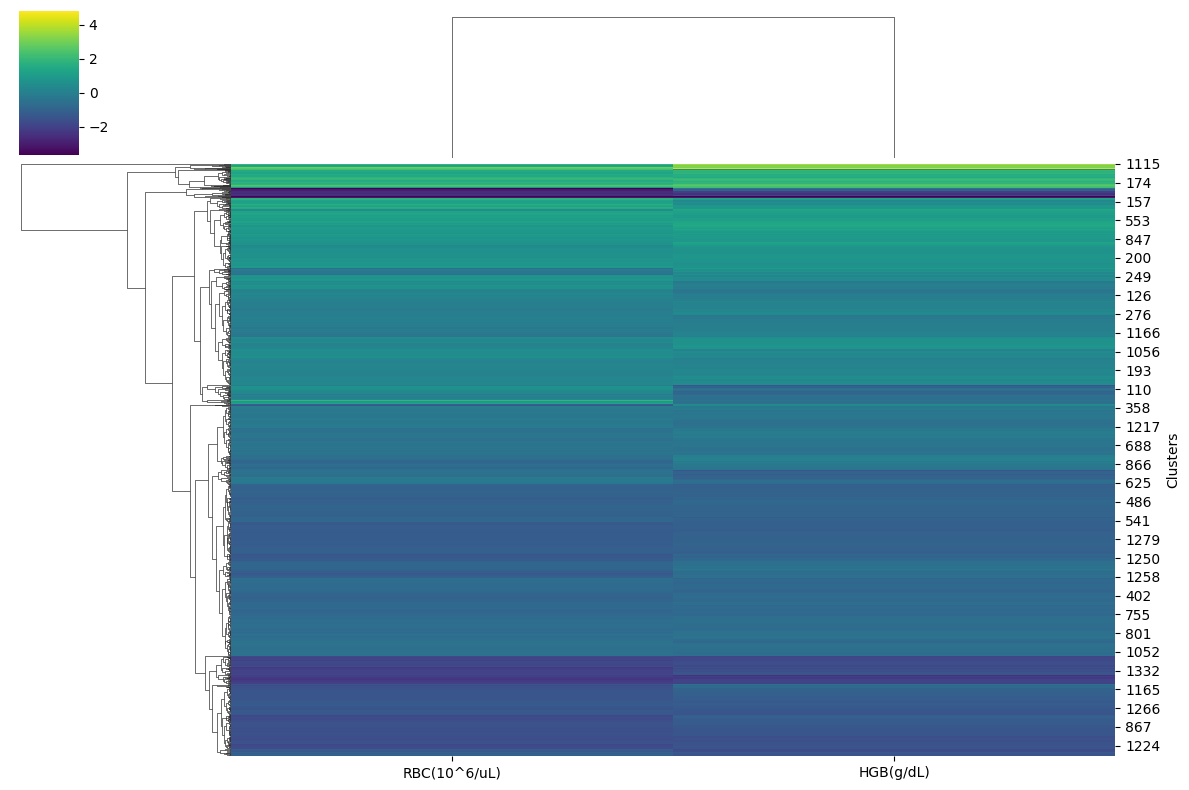

In [63]:
heatmap_data = second_copy.groupby('Clusters')[['RBC(10^6/uL)', 'HGB(g/dL)']].median()
sns.clustermap(heatmap_data, cmap='viridis', figsize=(12, 8)) # 'WBC(10^3/uL)'
plt.show()

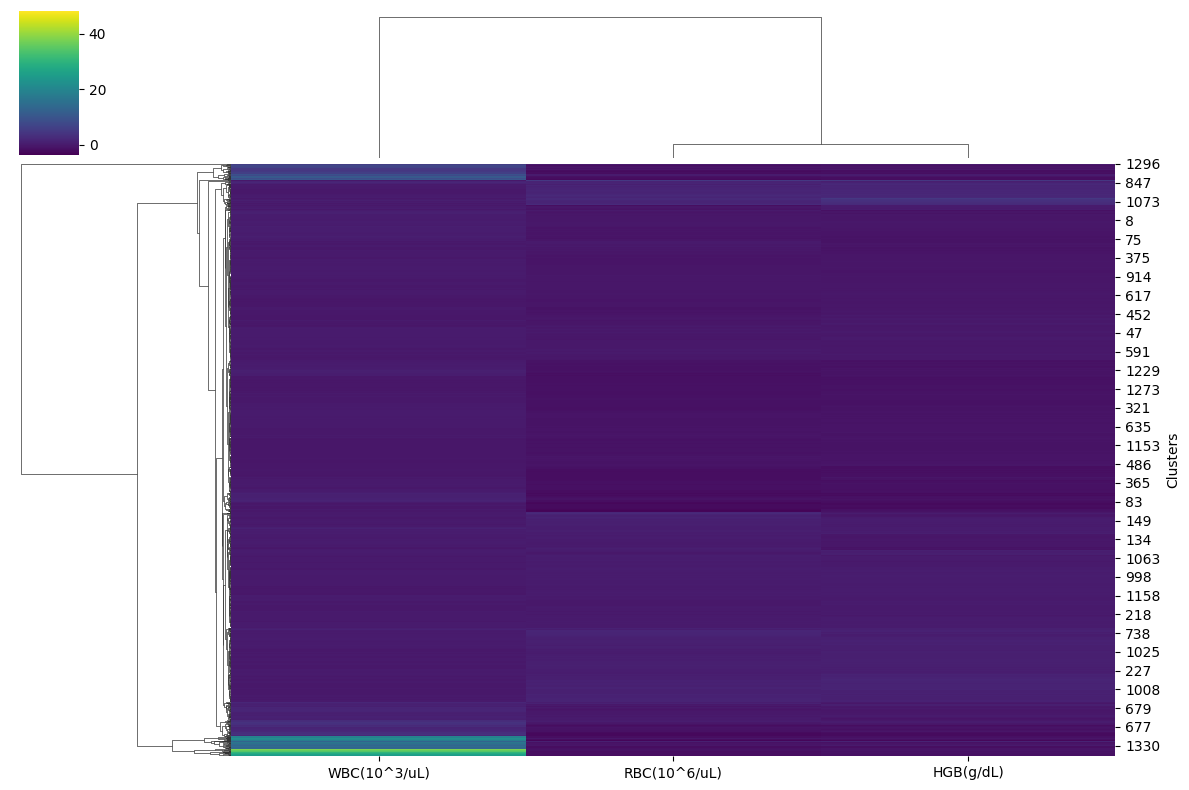

In [64]:
heatmap_data = second_copy.groupby('Clusters')[['WBC(10^3/uL)', 'RBC(10^6/uL)', 'HGB(g/dL)']].median()
sns.clustermap(heatmap_data, cmap='viridis', figsize=(12, 8))
plt.show()

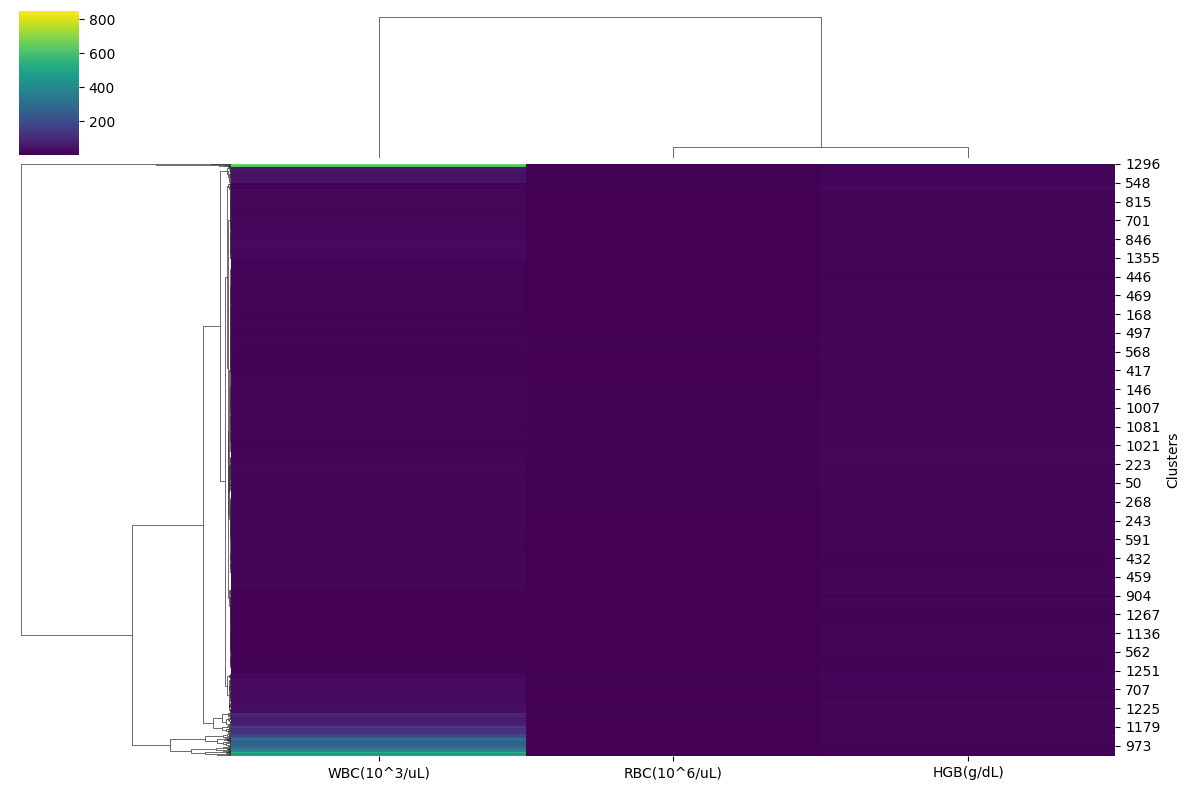

In [65]:
heatmap_data = df.groupby('Clusters')[['WBC(10^3/uL)', 'RBC(10^6/uL)', 'HGB(g/dL)']].median()
sns.clustermap(heatmap_data, cmap='viridis', figsize=(12, 8))
plt.show()

In [66]:
df.loc[df['Revised final diagnosis'].isna(), 'Revised final diagnosis'] = 'No diagnosis'
df

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),NRBC#(10^3/uL),NRBC%(%),...,[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ],Revised final diagnosis,Clusters
0,3.02,2.42,5.6,17.8,73.6,23.1,31.5,87.0,0.14,4.6,...,580.0,657.0,772.0,602.0,706.0,368.0,837.0,743.0,No diagnosis,1345
1,17.42,5.15,15.1,44.4,86.2,29.3,34.0,552.0,1.17,6.7,...,725.0,759.0,725.0,940.0,741.0,366.0,913.0,786.0,No diagnosis,1348
2,6.87,4.44,12.1,36.2,81.5,27.3,33.4,242.0,0.43,6.3,...,708.0,727.0,735.0,756.0,697.0,316.0,762.0,767.0,No diagnosis,1353
3,7.04,4.50,12.0,36.5,81.1,26.7,32.9,227.0,0.36,5.1,...,667.0,712.0,754.0,708.0,653.0,368.0,753.0,709.0,No diagnosis,1353
4,2.86,2.31,5.6,17.1,74.0,24.2,32.7,88.0,0.17,5.9,...,622.0,795.0,771.0,718.0,738.0,374.0,796.0,686.0,No diagnosis,1345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79408,6.24,2.27,7.1,21.3,93.8,31.3,33.3,38.0,0.00,0.0,...,741.0,1093.0,490.0,987.0,566.0,323.0,927.0,883.0,Acute myeloid leukemia non M3,1224
79409,56.99,3.65,11.2,35.0,95.9,30.7,32.0,59.0,0.00,0.0,...,815.0,724.0,526.0,948.0,572.0,248.0,710.0,677.0,Chronic lymphocytic leukemia,980
79410,9.04,3.41,10.6,34.0,99.7,31.1,31.2,171.0,0.00,0.0,...,639.0,633.0,587.0,997.0,568.0,256.0,673.0,597.0,Multiple myeloma,210
79411,12.68,1.91,6.9,20.2,105.8,36.1,34.2,27.0,0.00,0.0,...,717.0,746.0,540.0,1299.0,805.0,348.0,779.0,708.0,Acute myeloid leukemia non M3,327


In [67]:
second_copy['Revised final diagnosis'] = mapped_labels

### What is this classifier thing?

In [68]:
# # Train classifier to find important features
# clf = RFC().fit(second_copy, second_copy['Clusters'])
# top_features = pd.Series(clf.feature_importances_, index=second_copy.columns).nlargest(5).index

# # Plot
# sns.boxplot(data=second_copy, x='Clusters', y=top_features[0], hue='Revised final diagnosis', showfliers=False)
# # plt.axhline(y=11, color='r', linestyle='--', label='Normal WBC upper limit')  # Example threshold

In [69]:
cluster_stats

,WBC(10^3/uL)_median,WBC(10^3/uL)_min,WBC(10^3/uL)_max,WBC(10^3/uL)_IQR,RBC(10^6/uL)_median,RBC(10^6/uL)_min,RBC(10^6/uL)_max,RBC(10^6/uL)_IQR,HGB(g/dL)_median,HGB(g/dL)_min,HGB(g/dL)_max,HGB(g/dL)_IQR
Clusters,,,,,,,,,,,,
1,0.490,0.49,0.49,0.000,4.660,4.66,4.66,0.000,18.0,18.0,18.0,0.0
2,1.290,1.29,1.29,0.000,3.420,3.42,3.42,0.000,14.6,14.6,14.6,0.0
3,11.910,11.91,11.91,0.000,2.890,2.89,2.89,0.000,8.3,8.3,8.3,0.0
4,30.330,30.33,30.33,0.000,2.390,2.39,2.39,0.000,6.7,6.7,6.7,0.0
5,11.940,11.94,11.94,0.000,2.770,2.77,2.77,0.000,8.6,8.6,8.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1360,58.040,58.04,58.04,0.000,3.660,3.66,3.66,0.000,9.4,9.4,9.4,0.0
1361,102.860,102.86,102.86,0.000,2.990,2.99,2.99,0.000,7.8,7.8,7.8,0.0
1362,44.615,44.44,44.79,0.175,0.725,0.72,0.73,0.005,2.1,2.1,2.1,0.0


### An atlas of some sorts

In [70]:
atlas_descriptions = []
for cluster in outliers:
    desc = f"Cluster {cluster}: {outliers[cluster]}. Ranges: WBC={cluster_stats.loc[cluster, 'WBC(10^3/uL)_min']:.1f}-{cluster_stats.loc[cluster, 'WBC(10^3/uL)_max']:.1f}, Hb={cluster_stats.loc[cluster, 'HGB(g/dL)_min']:.1f}-{cluster_stats.loc[cluster, 'HGB(g/dL)_min']:.1f}"
    atlas_descriptions.append(desc)

# Save to CSV
pd.DataFrame(atlas_descriptions, columns=['Description']).to_csv('cluster_atlas.csv')

In [71]:
atlas_descriptions[:5]

['Cluster 1: . Ranges: WBC=0.5-0.5, Hb=18.0-18.0',
 'Cluster 2: . Ranges: WBC=1.3-1.3, Hb=14.6-14.6',
 'Cluster 3: ↑WBC (median=11.9), ↓Hb (median=8.3). Ranges: WBC=11.9-11.9, Hb=8.3-8.3',
 'Cluster 4: ↑WBC (median=30.3), ↓Hb (median=6.7). Ranges: WBC=30.3-30.3, Hb=6.7-6.7',
 'Cluster 5: ↑WBC (median=11.9), ↓Hb (median=8.6). Ranges: WBC=11.9-11.9, Hb=8.6-8.6']

In [72]:
def mean_ci(data, confidence=0.95):
    n = len(data)
    mean, std = np.mean(data), np.std(data)
    h = std * t.ppf((1 + confidence) / 2, n - 1) / np.sqrt(n)
    return mean - h, mean + h

In [73]:
wbc_ci = df.groupby('Clusters')['WBC(10^3/uL)'].apply(mean_ci)

In [74]:
wbc_ci

Clusters
1                                   (nan, nan)
2                                   (nan, nan)
3                                   (nan, nan)
4                                   (nan, nan)
5                                   (nan, nan)
                         ...                  
1360                                (nan, nan)
1361                                (nan, nan)
1362    (43.04268738185173, 46.18731261814826)
1363     (24.222542873988008, 34.877457126012)
1364                                (nan, nan)
Name: WBC(10^3/uL), Length: 1263, dtype: object